## To Do
1. Make single site channel code
2. Quantum simulation
3. MI in boundary dissipation∂

In [2]:
import numpy as np
%matplotlib qt
import matplotlib.pyplot as pl
import time
import pickle
import os
import math

In [3]:
from transfer_matrix import load_bit_state, free_energy_uniform, State, get_U_haar, get_U_k_1, get_U_t_1

In [4]:
def get_ancilla_array(L,T,pattern='random',preference='E',seed=1,p_O=0.5): #preference decides to give preference to E or O for initial time step in case they cannot be equally distributed
    """
    -1 corresponds to ancilla given to Environment
    +1 corresponds to ancilla given to Observer
    0 corresponds to there being no ancilla at that site
    E.g, a_structure[t,x] = -1 means that the ancilla at (x,t) belongs to Environemnt
    """
    if pattern == 'checkerboard':
        a_structure = (np.indices((T,L)).sum(axis=0) % 2)
        if preference == 'E':
            a_structure = 2*a_structure - 1
        elif preference == 'O':
            a_structure = 1-2*a_structure

    if pattern == 'alternate':
        a_structure = np.ones((T,L))
        for t in range(T):
            if preference == 'E':
                if t%2==0:
                    a_structure[t,:] = -1
            elif preference == 'O':
                if t%2==1:
                    a_structure[t,:] = -1

    if pattern == 'random':
        rng = np.random.default_rng(seed=seed)
        a_structure = np.round(rng.binomial(1,p_O,(T,L)))
        a_structure = 2*a_structure - 1

    if pattern == 'boundary':
        a_structure = np.zeros((T,L))
        a_structure[::2,0] = -1
        # a_structure[::1,-1] = -1
        
    return a_structure

In [5]:
## Calculate coherent QI for a single encoded bell pair.
def delta_F(L,p,q,pattern='random',seed=1,preference='E',intermediate_time=False,p_O=0.5,BC='PBC'):

    T = 10*L
  
    F_t = []
    # Load initial_states
    state_up = load_bit_state(L,2*L,q,'up')
    state_down = load_bit_state(L,2*L,q,'down')
    state_up.p = p
    state_down.p = p

    # initial_up = np.zeros((2,)*L)
    # initial_up[:,1] = 1
    # sd = initial_up.sum()
    # initial_up = initial_up/sd
    # state_up = State(L=L,p=p,q=q,initial_state=initial_up)
    # state_up.log_Z = [0]

    # initial_down = np.zeros((2,)*L)
    # initial_down[:,0] = 1
    # sd = initial_down.sum()
    # initial_down = initial_down/sd
    # state_down = State(L=L,p=p,q=q,initial_state=initial_down)
    # state_down.log_Z = [0]

    # get ancilla structure. This is an array which decides whether the particular ancilla goes to O or E
    a_structure = get_ancilla_array(L,T,pattern=pattern,seed=seed,preference=preference,p_O=p_O)

    # Calculate free energy
    state_up,top_layer_up= free_energy_uniform(state_up,T,a_structure,intermediate_time=intermediate_time,BC=BC)
    state_down, top_layer_down= free_energy_uniform(state_down,T,a_structure,intermediate_time=intermediate_time,BC=BC)

    # Free energy difference as a function of time
    if intermediate_time:
        for t in range(T):
            temp_up = np.sum(state_up.log_Z[:1+t+1]) + top_layer_up[t]
            temp_down = np.sum(state_down.log_Z[:1+t+1]) + top_layer_down[t]
            F_t.append(temp_down-temp_up)
    else:
        temp_up = np.sum(state_up.log_Z[:1+T]) + top_layer_up[-1]
        temp_down = np.sum(state_down.log_Z[:1+T]) + top_layer_down[-1]
        F_t.append(temp_down-temp_up)
    return F_t       

## Alternate Scheme

In [7]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.1,1,20),2)
# p_list = [0.68]
intermediate_time = True
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    if intermediate_time: F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='boundary',preference='O',p_O=0,intermediate_time=intermediate_time,BC='OBC')
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.1  0.15 0.19 0.24 0.29 0.34 0.38 0.43 0.48 0.53 0.57 0.62 0.67 0.72
 0.76 0.81 0.86 0.91 0.95 1.  ]


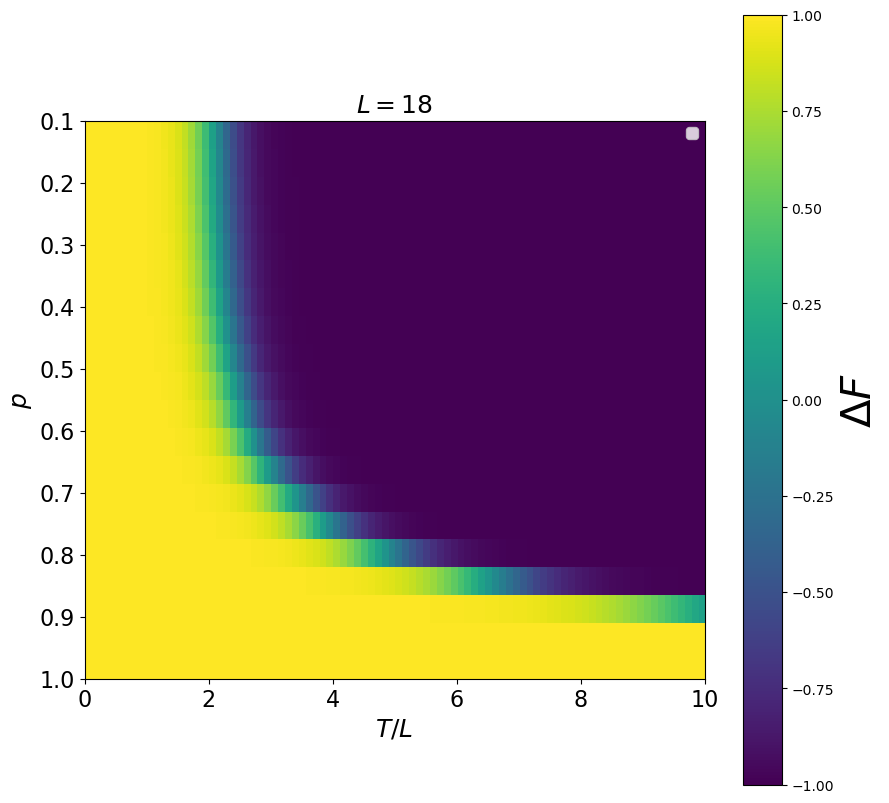

In [51]:
%matplotlib inline
L_list2 = L_list.copy()[-1:]
p_list2 = p_list[:][:]
print(p_list2)
prop_cycle = pl.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['o','1','s','^']
two_d_data = []
fig,ax=pl.subplots(1,1,figsize=(10,10))
for j,p in enumerate(p_list2):
    for i,L in enumerate(L_list2):
        y_data = (np.array(F_t[L][p])/np.log(q))
        two_d_data.append(y_data[::1])
        x_data = np.arange(0,len(y_data),1)/L
        # pl.plot(x_data[::2],y_data[::2],ls='-',marker=markers[j],label='L='+str(L)+'_p='+str(round(p,2)),color=colors[i])
ax.imshow(np.array(two_d_data),extent=[0,len(y_data)/L,p_list2[-1],p_list2[0]],aspect=10.0)
ax.tick_params(axis='both',labelsize=16)
cl = pl.colorbar(ax.get_images()[0])
cl.set_label(r'$\Delta F$',fontsize=30)
ax.set_xlabel(r'$T/L$',fontsize=18)
ax.set_ylabel(r'$p$',fontsize=18)
ax.set_title(r'$L='+str(L)+'$',fontsize=18)
pl.legend(ncol=len(p_list2))

In [15]:
%matplotlib qt
p_c = []
for t in range(1,21,1):
    L1 = 16
    L2 = 14
    F_1 = np.array([F_t[L1][p][t*L1//2-1] for p in F_t[L1]])
    F_2 = np.array([F_t[L2][p][t*L2//2-1] for p in F_t[L2]])
    diff = F_1-F_2
    index = np.where(diff>0)[0][0]
    p_c.append(p_list[index])
pl.plot(range(1,21,1),p_c,'-o')

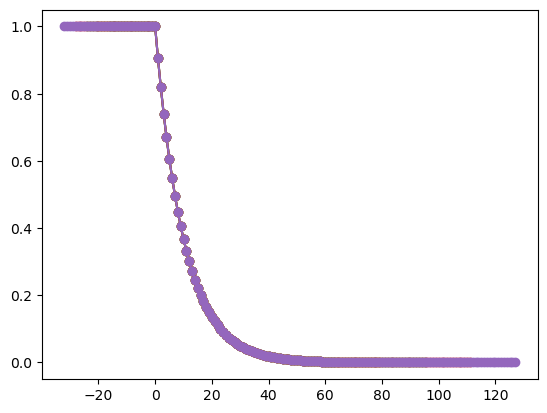

In [46]:
%matplotlib inline
v=2
for L in L_list:
    x_data = np.arange(0,10*L,1)
    y_data = np.zeros(10*L)
    y_data[0:v*L] = 1
    y_data[v*L:]= np.exp(-0.1*(x_data[v*L:]-v*L))
    pl.plot((x_data/L-2)*L,y_data,'-o')
# pl.yscale('log')

In [26]:
%matplotlib qt
p = p_list[15]
print(p)
fig,ax = pl.subplots(1,1,sharey=False)
for L in F_t:
    T_data = np.arange(0,len(F_t[L][p]),1)/(L**1)
    ax.plot((T_data[::2]-4.951)*L,1+np.array(F_t[L][p][::2])/np.log(q),ls='-',marker='o',label='L='+str(L))
    # ax[1].plot((T_data[::2]-3.21)*L**(1/1),np.array(F_t[L][p][::2])/np.log(q),ls='',marker='o',label='L='+str(L))

# ax.set_yscale('log')

ax.set_ylabel(r'$1+\Delta F$',fontsize=16)
ax.set_xlabel(r'$(T/L-T_c)L$',fontsize=16)
# ax[1].set_xlabel(r'$(T/L-T_c)L^{1/\nu}$',fontsize=16)
# ax[1].set_title(r'$T_c=3.21,\nu=1$',fontsize=16)
# ax[0].set_xlim(1.5,4.5)
# ax[1].set_xlim(-30,30)
ax.set_title(r'$q=2,p='+str(round(p,2))+'$',fontsize=16)

pl.legend()

0.81


In [20]:
p_list[5]

0.34

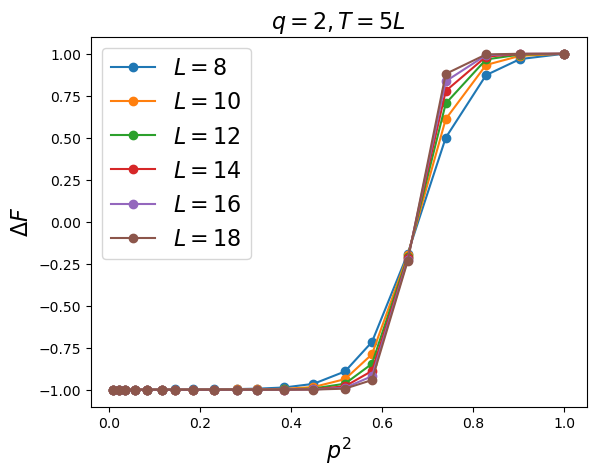

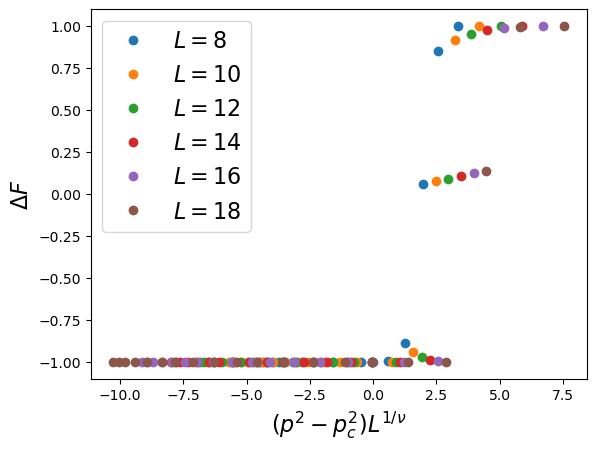

In [11]:
%matplotlib inline
p_c = 0.58
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
T_ratio = 5
for L in F:
    ax.plot(np.array(p_list)**2,np.array([F_t[L][p][T_ratio*L] for p in F_t[L]])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)**2-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))
ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p^2$',fontsize=16)
ax2.set_xlabel(r'$(p^2-p^2_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'$q=2,T='+str(T_ratio)+'L$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


## Checkerboard

In [43]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='checkerboard',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


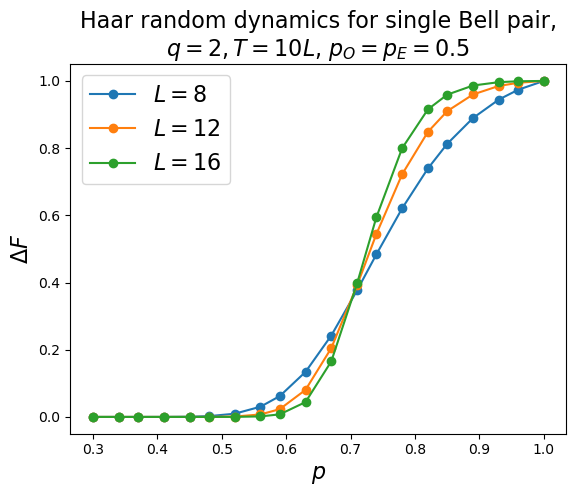

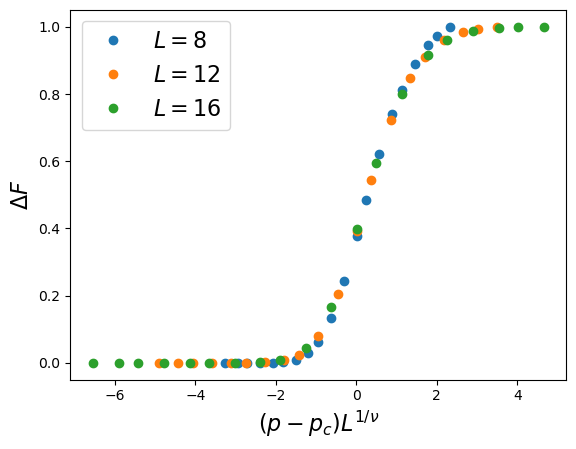

: 

In [47]:
%matplotlib inline
p_c = 0.7090
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    if L%4==2:
        continue
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


# Random

In [25]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = {}
    # F_t[L] = {}
    for p in p_list:
        F[L][p] = []
        for seed in np.arange(1,100,1):
            diff_F = delta_F(L,p,q,pattern='random',preference='E',intermediate_time=False,p_O=0.5,seed=seed)
            if intermediate_time: F_t[L][p] = diff_F
            F[L][p].append(diff_F[-1])


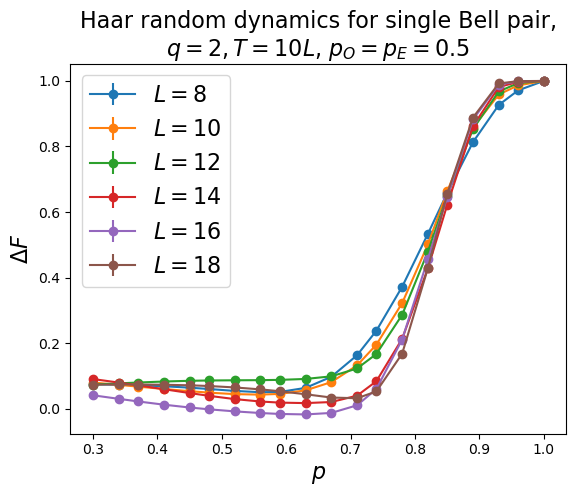

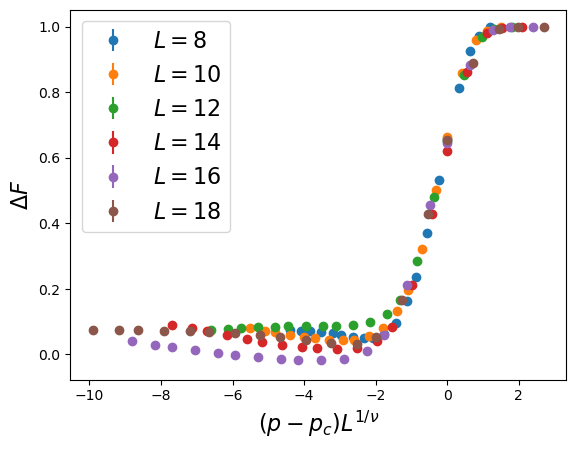

: 

In [27]:
%matplotlib inline
p_c = 0.85
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    # if L%4==2:
    #     continue
    F_avg = []
    F_err = []
    for p in F[L]:
        F_avg.append(np.average(F[L][p]))
        F_err.append(np.std(F[L][p])/len(F[L][p]))
    ax.errorbar(p_list,np.array(F_avg)/np.log(q),yerr=F_err/np.log(q),ls='-',marker='o',label = r'$L=$'+str(L))
    ax2.errorbar((np.array(p_list)-p_c)*L**(1/nu),np.array(F_avg)/np.log(q),yerr=F_err/np.log(q),ls='',marker='o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


# Boundary Disspiation

In [15]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.75,1,20),4)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='boundary',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


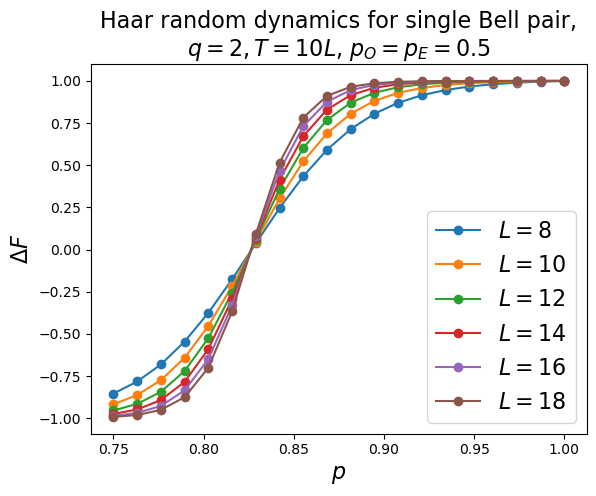

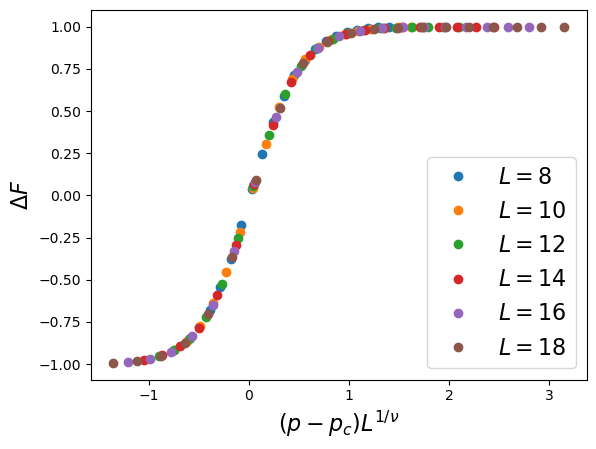

In [16]:
%matplotlib inline
p_c = 0.825
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


In [15]:
for L in [16]:
    for p in F_t[L]:
        T_data = np.arange(1,len(F_t[L][p])+1,1)[::2]/L
        pl.plot(T_data,np.array(F_t[L][p])[::2]/(np.log(q)),'-o',label = r'$p=$'+str(p))
pl.legend()

In [14]:
p_c = 0
nu = np.inf
for L in F:
    pl.plot((np.array(p_list)-p_c)*L**(1/nu),[np.array(F_t[L][p][-1])/np.log(q) for p in p_list],'-o',label = r'$L=$'+str(L))

pl.ylabel(r'$\Delta F$',fontsize=16)
pl.xlabel(r'$p$',fontsize=16)

pl.title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

pl.legend(fontsize=16)
pl.tight_layout()